In [1]:
from bs4 import BeautifulSoup
import re
import pandas as pd
from collections import OrderedDict

In [1]:
from  geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='hemnett')

In [2]:
with open("src/slutpriser/page1.html") as fp:
    soup = BeautifulSoup(fp)


In [3]:
def keep_digits(text):
    text = re.sub(r'[^\d,]', '', text.strip())
    text = text.replace(',', '.')
    if not text:
        return -100
    return float(text)

In [4]:
ul = soup.findAll('ul', {'class': 'normal-results'})[0]
listings = ul.findChildren('li', {'class': 'normal-results__hit'}, recursive=False)

parsed_listings = []
for listing in listings:
    address = listing.findChildren('h2', {'class': 'listing-card__street-address'})[0].text.strip()
    match = re.match(r'([A-ö0-9 ]*)(?=[ ,]+(\d+) ?tr)', address)
    if match:
        street, floor = match.groups()
    else:
        street, floor = address, -1
    
    try:
        loc = geolocator.geocode(street)
        lat, lon = loc.latitude, loc.longitude
    except:
        lat = lon = 0

    stats = listing.findChildren('div', {'class': 'listing-card__attribute'})
    price, area, rooms, rent, kr_sqm = [stat.text.strip() for stat in stats][:5]
    data = OrderedDict((
        ('street', street),
        ('floor', int(floor)),
        ('price', keep_digits(price)),
        ('area', keep_digits(area)),
        ('rooms', keep_digits(rooms)),
        ('rent', keep_digits(rent)),
        ('kr_sqm', keep_digits(kr_sqm)),
        ('lat', lat),
        ('lon', lon),
        ))
    parsed_listings.append(data)

df = pd.DataFrame(parsed_listings)

IndexError: list index out of range

In [12]:
df.to_csv('hemnet.csv')

In [48]:
BBox = (17.9499, 18.1732, 59.2924, 59.3977)

In [49]:
import matplotlib.pyplot as plt

In [50]:
ruh_m = plt.imread('map.png')

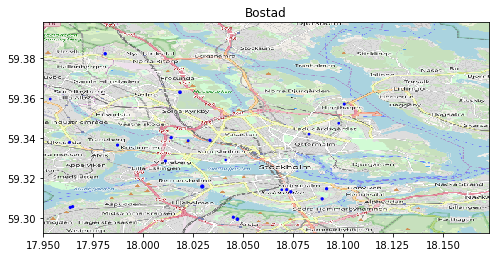

In [62]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df.lon, df.lat, zorder=1, alpha=1, c='b', s=(10*df.area/df.area.max()))
ax.set_title('Bostad')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')